In [1]:
import os
import pandas as pd
import pytz
import matplotlib
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import calendar
import numpy as np
import matplotlib.colors as mcolors
from datetime import datetime

%matplotlib inline

In [2]:
df = pd.read_parquet("path to machine metric dataset/surfsara_power_usage")

In [4]:
col_to_rack_name = dict()
for column in df.columns:
    rack = column.split("n")[0]
    
    if rack not in col_to_rack_name:
        col_to_rack_name[rack] = set()
    
    col_to_rack_name[rack].add(column)
    
gpu_nodes = {
    "r28n1", "r28n2", "r28n3", "r28n4", "r28n5",
    "r29n1", "r29n2", "r29n3", "r29n4", "r29n5",
    "r30n1", "r30n2", "r30n3", "r30n4", "r30n5", "r30n6", "r30n7",
    "r31n1", "r31n2", "r31n3", "r31n4", "r31n5", "r31n6"
    "r32n1", "r32n2", "r32n3", "r32n4", "r32n5", "r32n6", "r32n7",
    "r33n2", "r33n3", "r33n5", "r33n6",
    "r34n1", "r34n2", "r34n3", "r34n4", "r34n5", "r34n6", "r34n7",
    "r35n1", "r35n2", "r35n3", "r35n4", "r35n5",
    "r36n1", "r36n2", "r36n3", "r36n4", "r36n5",
    "r38n1", "r38n2", "r38n3", "r38n4", "r38n5",
}

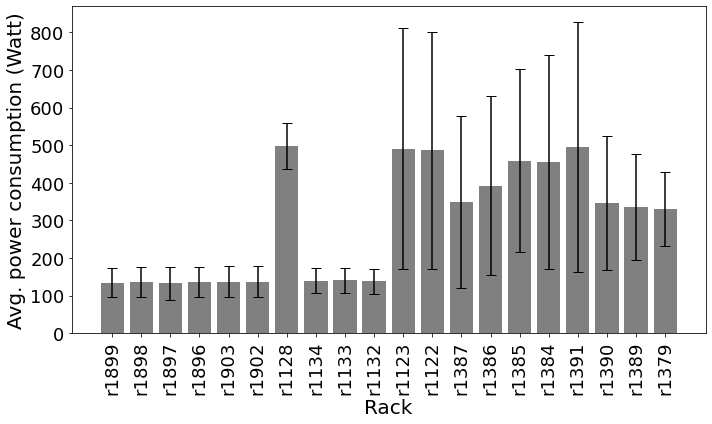

In [4]:
# This cell outputs a bar with eror bars depicting the average node power consumptions per rack

index = 0
fig, ax = plt.subplots(figsize=(11,5))

for rack, columns in col_to_rack_name.items():
    arr = df[list(columns)].values.ravel()
    arr = arr[arr >= 0]  # Filter all non-zero values


    ax.bar(index, arr.mean(), label=rack, yerr=arr.std(), capsize=5, color="grey")
    index += 1
    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Avg. power consumption (Watt)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xticks(np.arange(len(col_to_rack_name.keys())))
ax.set_xticklabels(col_to_rack_name.keys(), rotation = 90)

fig.tight_layout()
fig.savefig("average_power_consumption_per_node_per_rack.pdf")

In [13]:
# This and the next cell output a violin plot with the node power consumptions per rack
arrs = []
colors=[]

arrays = dict(
{
    "cpu_only": dict(),
    "cpu_gpu": dict()
})

for rack, columns in col_to_rack_name.items():
    arr = df[list(columns)].values.ravel()
    arr = arr[arr >= 0]  # Filter all non-zero values
    
    colors.append(mcolors.to_rgba("gray"))
    
    if any(c in gpu_nodes for c in columns):
#         colors.append(mcolors.to_rgba("red"))
        arrays["cpu_gpu"][rack] = arr
    else:
#         colors.append(mcolors.to_rgba("gray"))
        arrays["cpu_only"][rack] = arr

data = []
labels = []
pdf_max_values = []

def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

for k, v in sorted(arrays['cpu_only'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_only = len(data)

for k, v in sorted(arrays['cpu_gpu'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))  # Store the target and PDF value of the max PDF value
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_gpu = len(data) - num_cpu_only   
    
del arrays
del bl

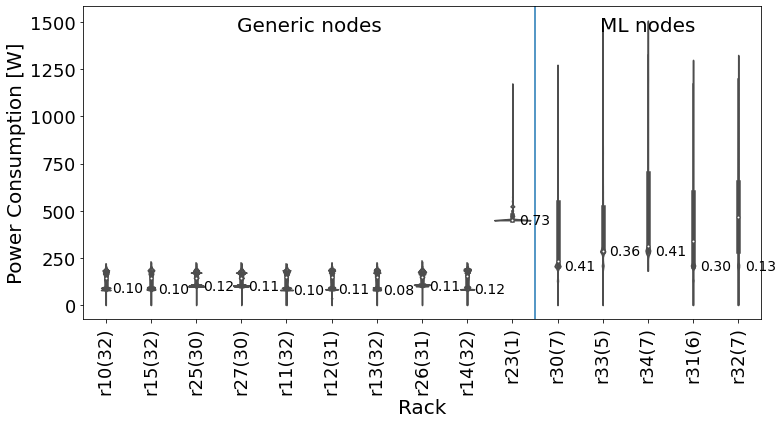

In [5]:
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=data, ax=ax, yerr=arr.std(), capsize=5, palette=colors, cut=0)

    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Power Consumption [W]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

horizontal_indices = np.arange(len(labels))
ax.set_xticks(horizontal_indices)
ax.set_xticklabels(labels, rotation = 90)

for index in horizontal_indices:
    ax.text(x=index + 0.15, y=pdf_max_values[index][0], s="{:.2f}".format(pdf_max_values[index][1]), fontsize=14, color="black", va="center")

# Draw a horizontal line separating the two groups
ax.axvline(x = num_cpu_only - .5)
# Add text to show what the groups depict
ax.text((num_cpu_only / 2) / (num_cpu_only + num_cpu_gpu), 0.92, 'Generic nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)
ax.text(((num_cpu_gpu / 2) +num_cpu_only)  / (num_cpu_only + num_cpu_gpu), 0.92, 'ML nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)

fig.tight_layout()
fig.savefig("average_power_consumption_for_nodes_in_rack_violin_{}.pdf".format(date_time))

In [ ]:
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig, ax = plt.subplots(figsize=(11, 5))
ax.set_rasterized(True)
sns.boxplot(data=data, ax=ax, color="lightcoral")

ax.set_ylim(0, 1700)

    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Power Consumption [W]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

horizontal_indices = np.arange(len(labels))
ax.set_xticks(horizontal_indices)
ax.set_xticklabels(labels, rotation = 90)

# for index in horizontal_indices:
#     ax.text(x=index + 0.15, y=pdf_max_values[index][0], s="{:.2f}".format(pdf_max_values[index][1]), fontsize=14, color="black", va="center")

# Draw a horizontal line separating the two groups
ax.axvline(x = num_cpu_only - .5)
# Add text to show what the groups depict
ax.text((num_cpu_only / 2) / (num_cpu_only + num_cpu_gpu), 0.92, 'Generic nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)
ax.text(((num_cpu_gpu / 2) +num_cpu_only)  / (num_cpu_only + num_cpu_gpu), 0.92, 'ML nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)

fig.tight_layout()
fig.savefig("average_power_consumption_for_nodes_in_rack_boxplot_{}.pdf".format(date_time))

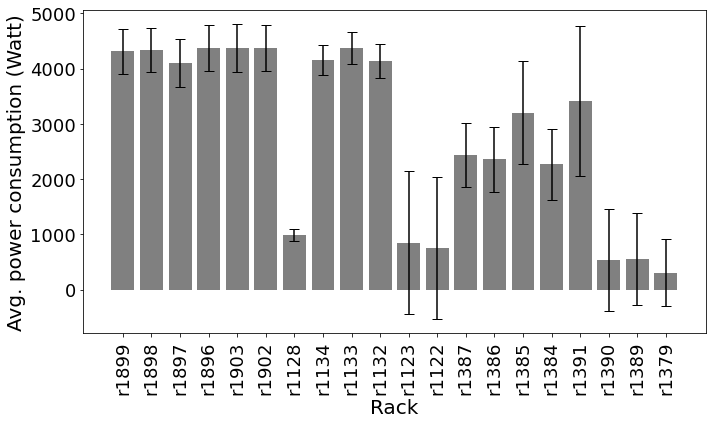

In [6]:
# This cell outputs a bar with eror bars depicting the average summed node power consumptions per rack
index = 0
fig, ax = plt.subplots(figsize=(11,5))

for rack, columns in col_to_rack_name.items():
    arr = df[list(columns)].fillna(0).replace(-1, 0).sum(axis=1).values.ravel()

    ax.bar(index, arr.mean(), label=rack, yerr=arr.std(), capsize=5, color="grey")
    index += 1
    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Avg. power consumption (Watt)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xticks(np.arange(len(col_to_rack_name.keys())))
ax.set_xticklabels(col_to_rack_name.keys(), rotation = 90)

fig.tight_layout()
fig.savefig("average_power_consumption_per_rack.pdf")

In [10]:
# # This cell outputs a violin plot with the summed node power consumptions per rack
# fig, ax = plt.subplots(figsize=(11,6))

# arrs = []
# colors = []

# for rack, columns in col_to_rack_name.items():
#     arr = df[list(columns)].fillna(0).replace(-1, 0).sum(axis=1).values.ravel()
#     colors.append(mcolors.to_rgba("red") if any(c in gpu_nodes for c in columns) else mcolors.to_rgba("gray"))
#     arrs.append(arr)
    

# sns.violinplot(data=arrs, ax=ax, width=0.95, palette=colors)

    
# ax.set_xlabel("Rack", fontsize=20)
# ax.set_ylabel("Power consumption (Watt)", fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=18)
# ax.tick_params(axis='both', which='minor', labelsize=16)

# ax.set_xticks(np.arange(len(col_to_rack_name.keys())))
# ax.set_xticklabels(col_to_rack_name.keys(), rotation = 90)

# fig.tight_layout()
# fig.savefig("average_power_consumption_per_rack_violin.pdf")

In [15]:
# This and the next cell output a violin plot with the summed node power consumptions per rack
arrs = []
colors=[]

arrays = dict(
{
    "cpu_only": dict(),
    "cpu_gpu": dict()
})

for rack, columns in col_to_rack_name.items():
    arr = df[list(columns)].fillna(0).replace(-1, 0).sum(axis=1).values.ravel()
    
    colors.append(mcolors.to_rgba("gray"))
    
    if any(c in gpu_nodes for c in columns):
#         colors.append(mcolors.to_rgba("red"))
        arrays["cpu_gpu"][rack] = arr
    else:
#         colors.append(mcolors.to_rgba("gray"))
        arrays["cpu_only"][rack] = arr

data2 = []
labels = []
pdf_max_values = []

def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

for k, v in sorted(arrays['cpu_only'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data2.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_only = len(data2)

for k, v in sorted(arrays['cpu_gpu'].items(), key=lambda x: np.median(x[1])):
    value_list = list(v)
    data2.append(value_list)
    
    bl = normalize(pd.DataFrame({"target": value_list}))
    
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))  # Store the target and PDF value of the max PDF value
    labels.append("{}({})".format(k, len(col_to_rack_name[k])))
    
num_cpu_gpu = len(data2) - num_cpu_only  
    
del arrays

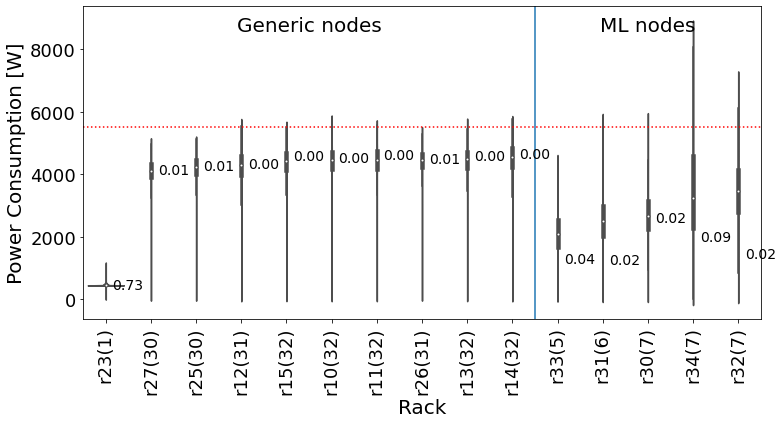

In [7]:
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig, ax = plt.subplots(figsize=(11, 5))
sns.violinplot(data=data2, ax=ax, yerr=arr.std(), capsize=5, palette=colors)

    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Power Consumption [W]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation = 90)

horizontal_indices = np.arange(len(labels))
for index in horizontal_indices:
    ax.text(x=index + 0.15, y=pdf_max_values[index][0], s="{:.2f}".format(pdf_max_values[index][1]), fontsize=14, color="black", va="center")

# Draw a horizontal line separating the two groups
ax.axvline(x = num_cpu_only - .5)
# Add text to show what the groups depict
ax.text((num_cpu_only / 2) / (num_cpu_only + num_cpu_gpu), 0.92, 'Generic nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)
ax.text(((num_cpu_gpu / 2) +num_cpu_only)  / (num_cpu_only + num_cpu_gpu), 0.92, 'ML nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)

# Draw a dotted line to depict the cooling treshold
ax.axhline(y=5500, linestyle="dotted", color="red")

fig.tight_layout()
fig.savefig("average_power_consumption_per_rack_violin_{}.pdf".format(date_time))

In [ ]:
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig, ax = plt.subplots(figsize=(11, 5))
ax.set_rasterized(True)
sns.boxplot(data=data2, ax=ax, color="lightcoral")

    
ax.set_xlabel("Rack", fontsize=20)
ax.set_ylabel("Power Consumption [W]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation = 90)

horizontal_indices = np.arange(len(labels))
# for index in horizontal_indices:
#     ax.text(x=index + 0.15, y=pdf_max_values[index][0], s="{:.2f}".format(pdf_max_values[index][1]), fontsize=14, color="black", va="center")

# Draw a horizontal line separating the two groups
ax.axvline(x = num_cpu_only - .5)
# Add text to show what the groups depict
ax.text((num_cpu_only / 2) / (num_cpu_only + num_cpu_gpu), 0.92, 'Generic nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)
ax.text(((num_cpu_gpu / 2) +num_cpu_only)  / (num_cpu_only + num_cpu_gpu), 0.92, 'ML nodes', horizontalalignment='center', transform=ax.transAxes, fontsize=20)

# Draw a dotted line to depict the cooling treshold
ax.axhline(y=5500, linestyle="dotted", color="red")

fig.tight_layout()
fig.savefig("average_power_consumption_per_rack_boxplot_{}.pdf".format(date_time))

In [7]:
gpu_values = np.array([])
non_gpu_values = np.array([])
pdf_max_values = []

for column in df.columns:
    arr = df[column].values
    mask = (np.isnan(arr) | (arr < 0))
    arr = arr[~mask]  # Filter out NaN values and less than 0
    if column in gpu_nodes:
        gpu_values = np.append(gpu_values, arr)
    else:
        non_gpu_values = np.append(non_gpu_values, arr)

del df

def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

def add_pdf_value(value_array):
    bl = normalize(pd.DataFrame({"target": value_array}))
    index_max_pdf = bl["pdf"].idxmax()
    row_with_max = bl.iloc[index_max_pdf]
    pdf_max_values.append((row_with_max['target'], row_with_max['pdf']))

add_pdf_value(non_gpu_values)
add_pdf_value(gpu_values)

target    1300.000000
pdf          0.058004
cdf          1.000000
dtype: float64

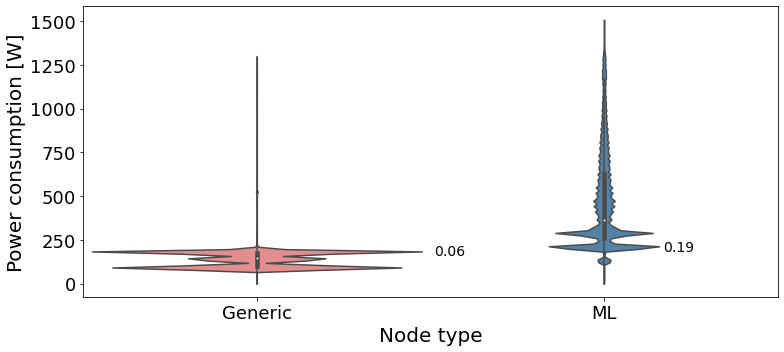

In [22]:
fig, ax = plt.subplots(figsize=(11,5))

colors = ['lightcoral', 'steelblue', 'yellowgreen']
     
sns.violinplot(data=[non_gpu_values, gpu_values], ax=ax, width=0.95, palette={0: "lightcoral", 1: "steelblue"}, cut=0)
ax.set_xlabel("Node type", fontsize=20)
ax.set_ylabel("Power consumption [W]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.set_xticks(np.arange(2))
ax.set_xticklabels(["Generic", "ML"])

horizontal_indices = np.arange(2)
label_positions = [0.51, 0.17]
for index in horizontal_indices:
    ax.text(x= index + label_positions[index], y=pdf_max_values[index][0], s="{:.2f}".format(pdf_max_values[index][1]), fontsize=14, color="black", va="center")

fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig("power_consumption_gpu_vs_non_gpu_violin_{}.pdf".format(date_time))

In [12]:
t = '''\\begin{{table}}[t]
\\caption{{Power consumption statistics for generic and ML \\textit{{nodes}}. The header lists percentiles.}}
\\label{{surfing:tbl:power-consumption-percentiles-per-node-type}}
\\adjustbox{{max width=\\linewidth}}{{
\\begin{{tabular}}{{@{{}}lrrrrrrrr@{{}}}}
\\toprule
    & 1\% & 25\% & 50\% & mean & 75\% & 99\% & 100\% \\\\ \\midrule
Generic & {1}    & {2}     & {3}     & {4}     & {5}     & {6} & {7}   \\\\
ML      & {8}    & {9}     & {10}     & {11}     & {12}     & {13} & {14}    \\\\ \\bottomrule
\\end{{tabular}}
}}
\\end{{table}}'''

percentiles = [1, 25, 75, 99, 100]
values = []

cpu_1, cpu_25, cpu_75, cpu_99, cpu_100 = np.percentile(non_gpu_values, percentiles)
cpu_mean = np.mean(non_gpu_values)
cpu_median = np.median(non_gpu_values)

gpu_1, gpu_25, gpu_75, gpu_99, gpu_100 = np.percentile(gpu_values, percentiles)
gpu_mean = np.mean(gpu_values)
gpu_median = np.median(gpu_values)

print(t.format(*["{:.2f}".format(v) for v in [
    cpu_1, cpu_25, cpu_median, cpu_mean, cpu_75, cpu_99, cpu_100,
    gpu_1, gpu_25, gpu_median, gpu_mean, gpu_75, gpu_99, gpu_100
]]))

\begin{table}[t]
\caption{Power consumption statistics for generic and ML \textit{nodes}. The header lists percentiles.}
\label{surfing:tbl:power-consumption-percentiles-per-node-type}
\adjustbox{max width=\linewidth}{
\begin{tabular}{@{}lrrrrrrrr@{}}
\toprule
    & 1\% & $25\% & 50\% & mean & 75\% & 99\% & 100\% \\ \midrule
Generic & 80.00    & 100.00     & 148.00     & 143.01     & 176.00     & 260.00 & 1300.00   \\
ML      & 130.00    & 260.00     & 364.00     & 467.16     & 624.00     & 1274.00 & 1508.00    \\ \bottomrule
\end{tabular}
}
\end{table}
